# Lot compounding

This notebook looks at methods on compounding lots; futures and options contracts that could be traded only in specific lots. Since these cannot be compounded in a fine grained manner, let us start with some simple methods.

Assumptions
------------

 1. Profit and loss is expressed in points per contract
 2. Capital required per contract is fairly stable over time. This is important in case you are **selling options**.
 3. Commissions and slippage is included in the profit and loss
 
 

In [1]:
import pandas as pd
import numpy as np
from typing import Union, List, Tuple

In [2]:
# parameters

probability_of_success = 0.66
success_payoff = 60 # Payoff in points
failure_payoff = 90 # Payoff in points
initial_capital: float = 100000
capital_per_lot:float = 40000 
lot_size:float = 50
buffer:float = 60000
num:int = 50 
sample:int = 1000

## Simple Method

In the simple method, we allocate capital per lot based on capital required per lot and add maximum expected loss for a single lot. Maximum expected loss is the maximum loss per trade multiplied by the number of expected consecutive losing trade. We assume we could **estimate maximum loss per trade reasonably well.**


Example
-------
    Lot size = 100
    Capital required per lot = 50000
    Maximum loss in points per trade = 100
    Expected consecutive losses = 5
    Expected maximum loss = 100*5*100 = 50000
    Total capital to be allocated = 50000+50000 = 100000
    

So, lots would be increased if we earn necessary capital per lot and we would keep on trading till we exhaust our buffer. In this case, we would increase the lot size if we earn 50000 and keep on trading till our total capital falls to 50000.

> Number of lots to trade = **int((total capital - expected maximum loss)/capital per lot)**


In [3]:
def lot_compounding(pnl:Union[pd.Series, List, Tuple], initial_capital:float=100000,
                   capital_per_lot:float=50000, buffer:float=50000, lot_size:float=100)->pd.DataFrame:
    """
    Compounding based on loss
    pnl
        profit or loss in points per contract
        points should not be multiplied by lot size
    initial_capital
        initial capital invested includes both capital per lot and buffer
    capital_per_lot
        capital required per lot
    buffer
        buffer for drawdown for a single lot
    lot_size
        lot size
    """
    capital = initial_capital
    capital_arr = []
    lots_arr = []
    profit_arr = []
    for p in pnl:
        lots = int((capital-buffer)/capital_per_lot)
        if lots == 0:
            if capital > capital_per_lot:
                lots = 1
        if lots > 0:
            profit = p*lot_size*lots
            capital += profit
        else:
            profit = 0
        capital_arr.append(capital)
        lots_arr.append(lots)
        profit_arr.append(profit)
        index = pnl.index if type(pnl)==pd.Series else np.arange(len(pnl))
    return pd.DataFrame({
        'lots': lots_arr,
        'capital': capital_arr,
        'profit': profit_arr,
    }, index=index)


In [4]:
payoffs = np.random.choice([success_payoff,0-abs(failure_payoff)], 
                 size=(sample,num), p=[probability_of_success, 1-probability_of_success])

In [5]:
collect = []
for p in payoffs:
    l = lot_compounding(p,initial_capital=initial_capital,
                       capital_per_lot=capital_per_lot, buffer=buffer, lot_size=lot_size)
    collect.append(l)
    

In [6]:
c2 = []
for c in collect:
    c7 = c.iloc[-1]
    c2.append((c7['capital'], c7['lots']))
df = pd.DataFrame(c2, columns=['capital', 'lots'])
df.describe()

,capital,lots
count,1000.000000,1000.000000
mean,123713.500000,1.273000
std,33160.085329,0.662503
min,38500.000000,0.000000
25%,107500.000000,1.000000
50%,122500.000000,1.000000
75%,136000.000000,1.000000
max,491500.000000,10.000000


Lot size distribution


<AxesSubplot:xlabel='lots', ylabel='Density'>

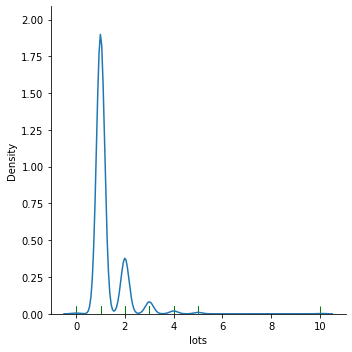

In [7]:
import seaborn as sns
print("Lot size distribution")
sns.displot(data=df, x='lots', kind='kde')
sns.rugplot(data=df, x='lots', color='green')

Capital distribution


<AxesSubplot:xlabel='capital', ylabel='Density'>

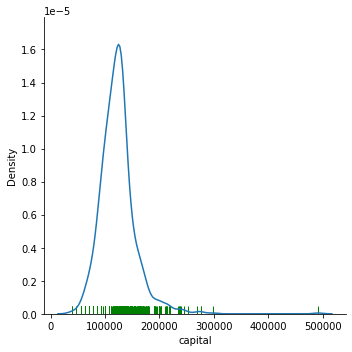

In [8]:
print("Capital distribution")
sns.displot(data=df, x='capital', kind='kde')
sns.rugplot(data=df, x='capital', color='green')